In [3]:
!pip install tensorflow

     |████████████████████████████████| 173.9 MB 13.9 MB/s eta 0:00:01     |███████████████████████████     | 146.4 MB 21.9 MB/s eta 0:00:02
     |████████████████████████████████| 65 kB 18.4 MB/s eta 0:00:01
     |████████████████████████████████| 10.6 MB 11.4 MB/s eta 0:00:01
     |████████████████████████████████| 42 kB 5.1 MB/s  eta 0:00:01
     |████████████████████████████████| 462 kB 9.9 MB/s eta 0:00:01
     |████████████████████████████████| 1.0 MB 11.4 MB/s eta 0:00:01
     |████████████████████████████████| 57 kB 27.6 MB/s eta 0:00:01
     |████████████████████████████████| 127 kB 18.3 MB/s eta 0:00:01
     |████████████████████████████████| 3.3 MB 14.2 MB/s eta 0:00:01
     |████████████████████████████████| 96 kB 7.7 MB/s eta 0:00:011
     |████████████████████████████████| 781 kB 8.2 MB/s eta 0:00:01
     |████████████████████████████████| 135 kB 20.6 MB/s eta 0:00:01
     |████████████████████████████████| 155 kB 14.0 MB/s eta 0:00:01
     |██████████████████████████████

In [1]:
!pip3 install tensorflow sklearn

  Created wheel for sklearn: filename=sklearn-0.0-py2.py3-none-any.whl size=1316 sha256=dc26a28fcd77c3b8fa2c07063387750c45955e1f21bce9c57df5203239382c13
  Stored in directory: /Users/harold/Library/Caches/pip/wheels/22/0b/40/fd3f795caaa1fb4c6cb738bc1f56100be1e57da95849bfc897
Successfully built sklearn


In [1]:
import numpy as np
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Flatten, BatchNormalization, Conv2D, MaxPool2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.metrics import confusion_matrix

In [2]:
import itertools
import os
import shutil
import random
import glob
import matplotlib.pyplot as plt
import warnings

warnings.simplefilter(action="ignore", category=FutureWarning)

In [3]:
tf.config.experimental.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [4]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [5]:
physical_devices = tf.config.experimental.list_physical_devices("GPU")
print("Number of GPUs available:", len(physical_devices))
if len(physical_devices) > 0:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)


Number of GPUs available: 1


In [6]:
os.chdir("data/dogs-vs-cats")

if os.path.isdir("train/dog") is False:
    for act in ["train", "valid", "test"]:
        for cls in ("dog", "cat"):
            os.makedirs("/".join([act, cls]))
            
            num_samples = 500 if act == "train" else 100 if act == "valid" else 50
                        
            for f in random.sample(glob.glob("train/" + cls + "*"), num_samples):
                shutil.move(f, "/".join([act, cls]))
                
os.chdir("../../")

In [7]:
train_path = "data/dogs-vs-cats/train"
valid_path = "data/dogs-vs-cats/valid"
test_path = "data/dogs-vs-cats/test"

In [8]:
train_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input)\
    .flow_from_directory(directory=train_path, target_size=(224,224), classes=["cat","dog"], batch_size=10)
valid_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input)\
    .flow_from_directory(directory=valid_path, target_size=(224,224), classes=["cat","dog"], batch_size=10)
test_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input)\
    .flow_from_directory(directory=test_path, target_size=(224,224), classes=["cat","dog"], batch_size=10, shuffle=False)


Found 1000 images belonging to 2 classes.
Found 200 images belonging to 2 classes.
Found 100 images belonging to 2 classes.


In [9]:
assert train_batches.n == 1000
assert valid_batches.n == 200
assert test_batches.n == 100
assert train_batches.num_classes == valid_batches.num_classes == test_batches.num_classes == 2

In [10]:
imgs, labels = next(train_batches)

In [11]:
def plotImages(images_arr):
    fix, axes = plt.subplots(1, 10, figsize=(20,20))
    axes.flatten()
    for img,ax in zip(images_arr, axes):
        ax.imshow(img)
        ax.axis("off")
    plt.tight_layout()
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

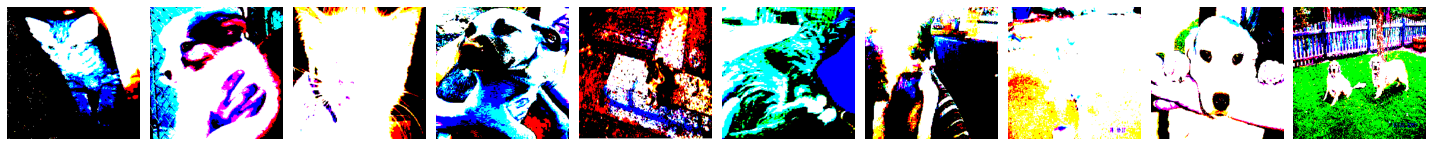

In [12]:
plotImages(imgs)

# Build CNN and Train

In [13]:
model = Sequential([
    Conv2D(filters=32, kernel_size=(3,3), activation="relu", padding="same", input_shape=(224,224,3)),
    MaxPool2D(pool_size=(2,2), strides=2),
    Conv2D(filters=64, kernel_size=(3,3), activation="relu", padding="same"),
    MaxPool2D(pool_size=(2,2), strides=2),
    Flatten(),
    Dense(units=2, activation="softmax"),
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 224, 224, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 112, 112, 64)      18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 56, 56, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 200704)            0         
_________________________________________________________________
dense (Dense)                (None, 2)                 401410    
Total params: 420,802
Trainable params: 420,802
Non-trainable params: 0
__________________________________________________

In [14]:
model.compile(optimizer=Adam(learning_rate=0.0001), loss="categorical_crossentropy", metrics=["accuracy"])

In [ ]:
with tf.device("device:GPU:0"):
    model.fit(x=train_batches, validation_data=valid_batches, epochs=10, verbose=2)

Epoch 1/10


# Predict

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

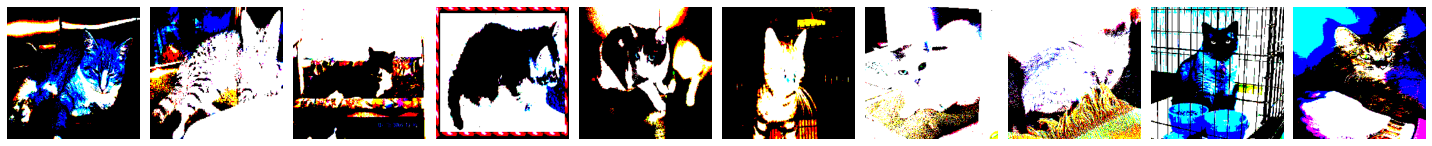

[[1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]]


In [15]:
test_imgs, test_labels = next(test_batches)

plotImages(test_imgs)

print(test_labels)

In [16]:
test_batches.classes

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32)

In [17]:
predictions = model.predict(x=test_batches, verbose=0)

In [18]:
np.round(predictions)

array([[1., 0.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.

In [19]:
cm = confusion_matrix(y_true=test_batches.classes, y_pred=np.argmax(predictions, axis=-1))

In [20]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [21]:
test_batches.class_indices

{'cat': 0, 'dog': 1}

Confusion matrix, without normalization
[[37 13]
 [13 37]]


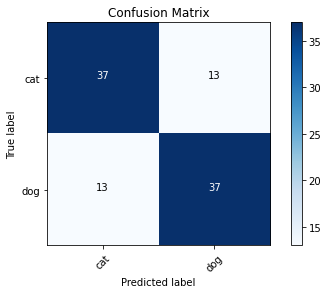

In [22]:
cm_plot_labels = ["cat", "dog"]
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title="Confusion Matrix")

# VGG16

In [23]:
vgg16_model = tf.keras.applications.vgg16.VGG16()

In [24]:
vgg16_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [25]:
def count_params(model):
    non_trainable_params = np.sum([np.prod(v.get_shape().as_list()) for v in model.non_trainable_weights])
    trainable_params = np.sum([np.prod(v.get_shape().as_list()) for v in model.trainable_weights])
    return {"non_trainable_params": non_trainable_params, "trainable_params": trainable_params}

In [26]:
params = count_params(vgg16_model)
assert params['non_trainable_params'] == 0
assert params['trainable_params'] == 138357544

In [27]:
model = Sequential()

for layer in vgg16_model.layers[:-1]:
    model.add(layer)

In [28]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 56, 56, 256)      

In [29]:
for layer in model.layers:
    layer.trainable = False

In [30]:
model.add(Dense(units=2, activation="softmax"))

In [31]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 56, 56, 256)      

In [32]:
model.compile(optimizer=Adam(learning_rate=0.0001), loss="categorical_crossentropy", metrics=["accuracy"])

In [33]:
model.fit(x=train_batches, validation_data=valid_batches, epochs=5, verbose=2)

Epoch 1/5
100/100 - 72s - loss: 0.2947 - accuracy: 0.8810 - val_loss: 0.1134 - val_accuracy: 0.9550
Epoch 2/5
100/100 - 78s - loss: 0.1019 - accuracy: 0.9640 - val_loss: 0.0758 - val_accuracy: 0.9700
Epoch 3/5
100/100 - 79s - loss: 0.0742 - accuracy: 0.9730 - val_loss: 0.0630 - val_accuracy: 0.9750
Epoch 4/5
100/100 - 79s - loss: 0.0581 - accuracy: 0.9820 - val_loss: 0.0580 - val_accuracy: 0.9750
Epoch 5/5
100/100 - 79s - loss: 0.0448 - accuracy: 0.9870 - val_loss: 0.0596 - val_accuracy: 0.9800


# Predict using fine-tuned VGG16 model

In [34]:
predictions = model.predict(x=test_batches, verbose=0)

In [35]:
test_batches.classes

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32)

In [36]:
cm = confusion_matrix(y_true=test_batches.classes, y_pred=np.argmax(predictions, axis=-1))

In [37]:
test_batches.class_indices

{'cat': 0, 'dog': 1}

Confusion matrix, without normalization
[[46  4]
 [ 2 48]]


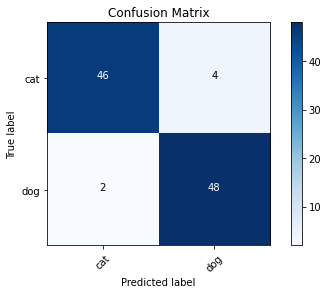

In [38]:
cm_plot_labels = ["cat", "dog"]
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title="Confusion Matrix")